
Wavelet Transform
============
This tutorial demonstrates how we can use the signal processing tools within Pynapple to aid with data analysis.
We will examine the dataset from [Grosmark & Buzsáki (2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4919122/).

Specifically, we will examine Local Field Potential data from a period of active traversal of a linear track.

This tutorial was made by [Kipp Freud](https://kippfreud.com/).


!!! warning
    This tutorial uses matplotlib for displaying the figure

    You can install all with `pip install matplotlib requests tqdm seaborn`


First, import the necessary libraries:

mkdocs_gallery_thumbnail_number = 6



In [3]:
import math
import os

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn
import tqdm

seaborn.set_theme()
import pynapple as nap

***
Downloading the data
------------------
Let's download the data and save it locally



In [4]:
path = "Achilles_10252013_EEG.nwb"
if path not in os.listdir("."):
    r = requests.get(f"https://osf.io/2dfvp/download", stream=True)
    block_size = 1024 * 1024
    with open(path, "wb") as f:
        for data in tqdm.tqdm(
            r.iter_content(block_size),
            unit="MB",
            unit_scale=True,
            total=math.ceil(int(r.headers.get("content-length", 0)) // block_size),
        ):
            f.write(data)
# Let's load and print the full dataset.
data = nap.load_file(path)
print(data)

Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


First we can extract the data from the NWB. The local field potential has been downsampled to 1250Hz. We will call it `eeg`.

The `time_support` of the object `data['position']` contains the interval for which the rat was running along the linear track. We will call it `wake_ep`.




In [5]:
FS = 1250

eeg = data["eeg"]

wake_ep = data["position"].time_support

***
Selecting example
-----------------------------------
We will consider a single run of the experiment - where the rodent completes a full traversal of the linear track,
followed by 4 seconds of post-traversal activity.



In [6]:
forward_ep = data["forward_ep"]
RUN_interval = nap.IntervalSet(forward_ep.start[7], forward_ep.end[7] + 4.0)

eeg_example = eeg.restrict(RUN_interval)[:, 0]
pos_example = data["position"].restrict(RUN_interval)

***
Plotting the LFP and Behavioural Activity
-----------------------------------



(18350.987054555, 18357.598245462)

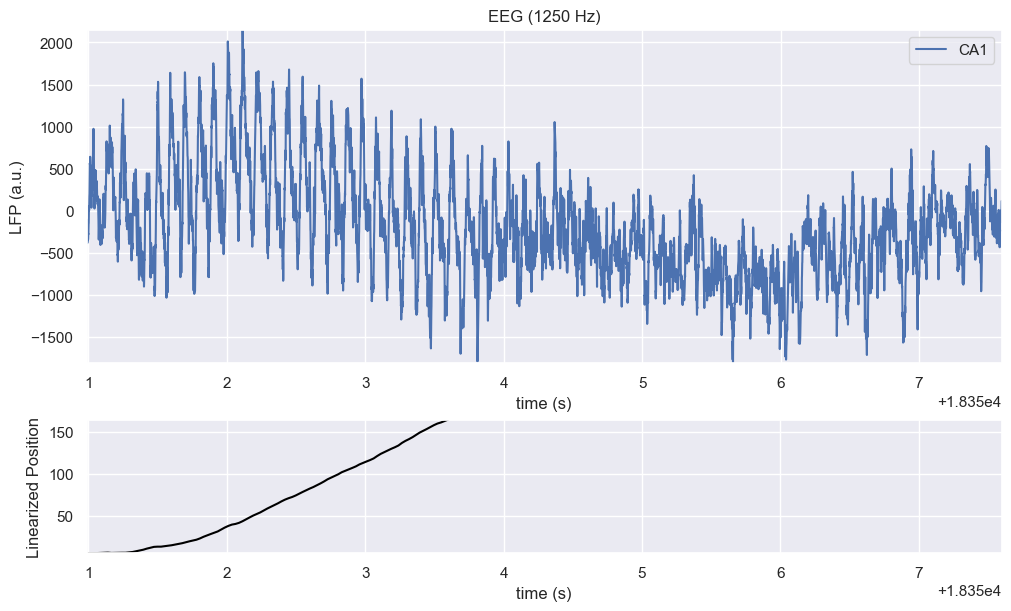

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
axd = fig.subplot_mosaic(
    [["ephys"], ["pos"]],
    height_ratios=[1, 0.4],
)
axd["ephys"].plot(eeg_example, label="CA1")
axd["ephys"].set_title("EEG (1250 Hz)")
axd["ephys"].set_ylabel("LFP (a.u.)")
axd["ephys"].set_xlabel("time (s)")
axd["ephys"].margins(0)
axd["ephys"].legend()
axd["pos"].plot(pos_example, color="black")
axd["pos"].margins(0)
axd["pos"].set_xlabel("time (s)")
axd["pos"].set_ylabel("Linearized Position")
axd["pos"].set_xlim(RUN_interval[0, 0], RUN_interval[0, 1])

In the top panel, we can see the lfp trace as a function of time, and on the bottom the mouse position on the linear
track as a function of time. Position 0 and 1 correspond to the start and end of the trial respectively.



***
Getting the LFP Spectrogram
-----------------------------------
Let's take the Fourier transform of our data to get an initial insight into the dominant frequencies during exploration (`wake_ep`).



In [8]:
power = nap.compute_power_spectral_density(eeg, fs=FS, ep=wake_ep, norm=True)

print(power)

                             0
0.000000   -2.998350-0.000000j
0.000484   -2.126045-1.798974j
0.000967    0.007193-1.454977j
0.001451    1.349894-2.032784j
0.001935   -1.869699+1.231444j
...                        ...
624.997582  0.004652+0.015275j
624.998065 -0.007766-0.002666j
624.998549 -0.009759-0.007228j
624.999033 -0.018504+0.000828j
624.999516  0.026411-0.007301j

[1292172 rows x 1 columns]


***
The returned object is a pandas dataframe which uses frequencies as indexes and spectral power as values.

Let's plot the power between 1 and 100 Hz.



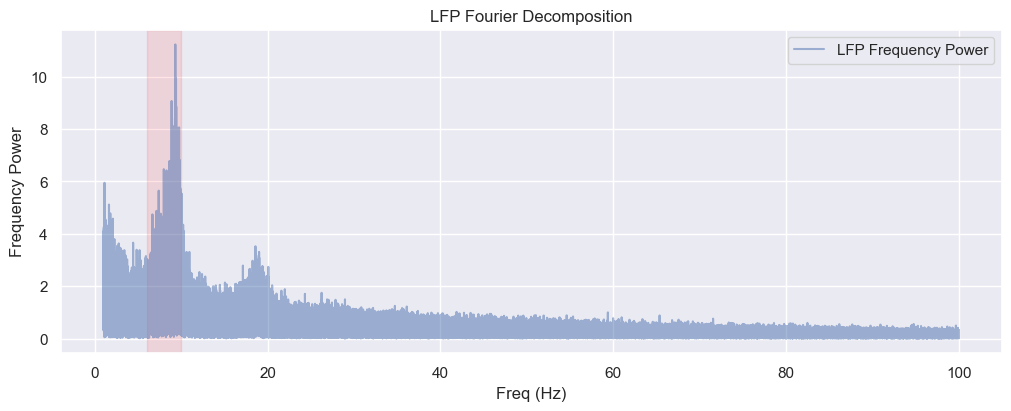

In [9]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(10, 4))
ax.plot(
    np.abs(power[(power.index >= 1.0) & (power.index <= 100)]),
    alpha=0.5,
    label="LFP Frequency Power",
)
ax.axvspan(6, 10, color="red", alpha=0.1)
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Frequency Power")
ax.set_title("LFP Fourier Decomposition")
ax.legend()

The red area outlines the theta rhythm (6-10 Hz) which is proeminent in hippocampal LFP.
Hippocampal theta rhythm appears mostly when the animal is running [1].
We can check it here by separating the wake epochs (`wake_ep`) into run epochs (`run_ep`) and rest epochs (`rest_ep`).



In [10]:
# The run epoch is the portion of the data for which we have position data
run_ep = data["position"].dropna().find_support(1)
# The rest epoch is the data at all points where we do not have position data
rest_ep = wake_ep.set_diff(run_ep)

`run_ep` and `rest_ep` are IntervalSet with discontinuous epoch.

The function `nap.compute_power_spectral_density` takes signal with a single epoch to avoid artefacts between epochs jumps.

To compare `run_ep` with `rest_ep`, we can use the function `nap.compute_mean_power_spectral_density` which avearge the FFT over multiple epochs of same duration. The parameter `interval_size` controls the duration of those epochs.

In this case, `interval_size` is equal to 1.5 seconds.



In [11]:
power_run = nap.compute_mean_power_spectral_density(
    eeg, 1.5, fs=FS, ep=run_ep, norm=True
)
power_rest = nap.compute_mean_power_spectral_density(
    eeg, 1.5, fs=FS, ep=rest_ep, norm=True
)

`power_run` and `power_rest` are the power spectral density when the animal is respectively running and resting.



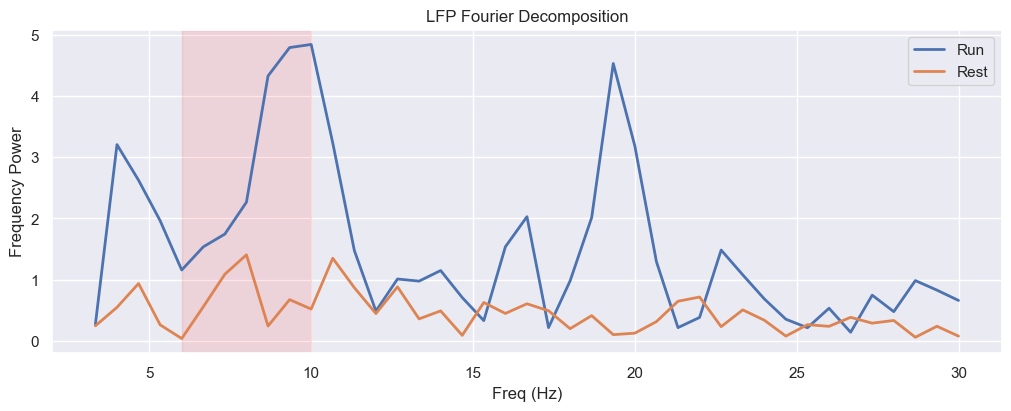

In [12]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(10, 4))
ax.plot(
    np.abs(power_run[(power_run.index >= 3.0) & (power_run.index <= 30)]),
    alpha=1,
    label="Run",
    linewidth=2,
)
ax.plot(
    np.abs(power_rest[(power_rest.index >= 3.0) & (power_rest.index <= 30)]),
    alpha=1,
    label="Rest",
    linewidth=2,
)
ax.axvspan(6, 10, color="red", alpha=0.1)
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Frequency Power")
ax.set_title("LFP Fourier Decomposition")
ax.legend()

***
Getting the Wavelet Decomposition
-----------------------------------
Overall, the prominent frequencies in the data vary over time. The LFP characteristics may be different when the animal is running along the track, and when it is finished.
Let's generate a wavelet decomposition to look more closely at the changing frequency powers over time.



In [13]:
# We must define the frequency set that we'd like to use for our decomposition
freqs = np.geomspace(3, 250, 100)

Compute and print the wavelet transform on our LFP data



In [14]:
mwt_RUN = nap.compute_wavelet_transform(eeg_example, fs=FS, freqs=freqs)

`mwt_RUN` is a TsdFrame with each column being the convolution with one wavelet at a particular frequency.



In [15]:
print(mwt_RUN)

Time (s)           0         1          2            3          4  ...
----------  --------  --------  ---------  -----------  ---------  -----
18350.9872  -29.5138  -17.7868   -7.10831    1.88067      8.98943  ...
18350.988   -29.9569  -18.2197   -7.49483    1.56739      8.76842  ...
18350.9888  -30.3972  -18.6531   -7.88538    1.24834      8.54098  ...
18350.9896  -30.8354  -19.0853   -8.27677    0.928843     8.30816  ...
18350.9904  -31.271   -19.5186   -8.67014    0.60495      8.06781  ...
18350.9912  -31.7048  -19.9511   -9.06579    0.273838     7.82063  ...
18350.992   -32.1359  -20.3819   -9.46504   -0.0634832    7.56765  ...
...
18357.5928  -20.6286  -26.8096  -29.9603   -30.8936     -30.2537   ...
18357.5936  -21.1723  -27.2476  -30.3018   -31.1502     -30.4452   ...
18357.5944  -21.7074  -27.6763  -30.633    -31.3964     -30.6275   ...
18357.5952  -22.2351  -28.0952  -30.9537   -31.6339     -30.7991   ...
18357.596   -22.7546  -28.5061  -31.2653   -31.8636     -30.9611   ...


***
Now let's plot it.



Text(0, 0.5, 'Pos.')

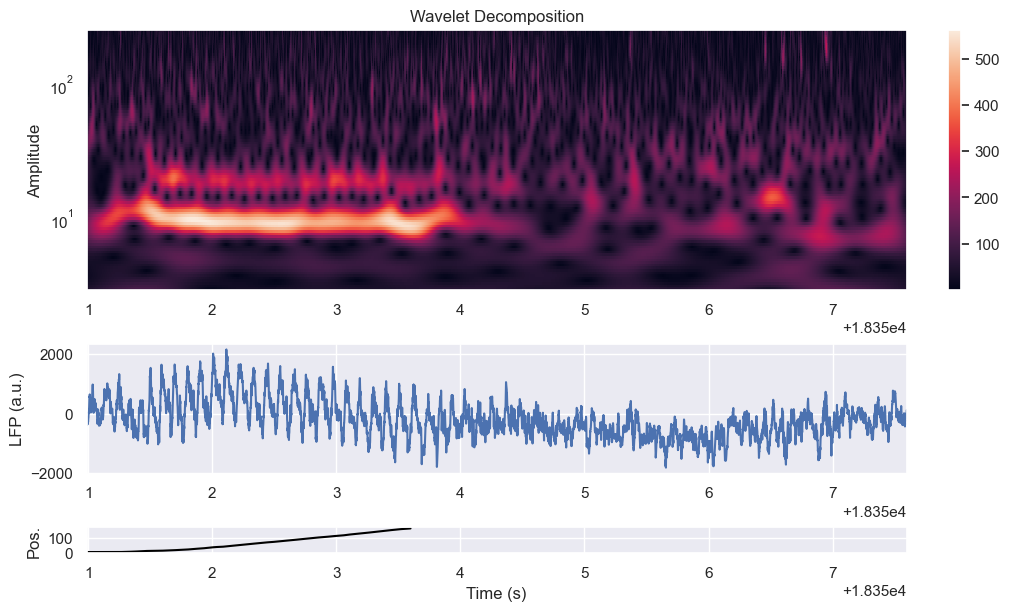

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = plt.GridSpec(3, 1, figure=fig, height_ratios=[1.0, 0.5, 0.1])

ax0 = plt.subplot(gs[0, 0])
pcmesh = ax0.pcolormesh(mwt_RUN.t, freqs, np.transpose(np.abs(mwt_RUN)))
ax0.grid(False)
ax0.set_yscale("log")
ax0.set_title("Wavelet Decomposition")
ax0.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pcmesh, ax=ax0, orientation="vertical")
ax0.set_ylabel("Amplitude")

ax1 = plt.subplot(gs[1, 0], sharex=ax0)
ax1.plot(eeg_example)
ax1.set_ylabel("LFP (a.u.)")

ax1 = plt.subplot(gs[2, 0], sharex=ax0)
ax1.plot(pos_example, color="black")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Pos.")

***
Visualizing Theta Band Power
-----------------------------------
There seems to be a strong theta frequency present in the data during the maze traversal.
Let's plot the estimated 6-10Hz component of the wavelet decomposition on top of our data, and see how well they match up.



In [17]:
theta_freq_index = np.logical_and(freqs > 6, freqs < 10)


# Extract its real component, as well as its power envelope
theta_band_reconstruction = np.mean(mwt_RUN[:, theta_freq_index], 1)
theta_band_power_envelope = np.abs(theta_band_reconstruction)

***
Now let's visualise the theta band component of the signal over time.



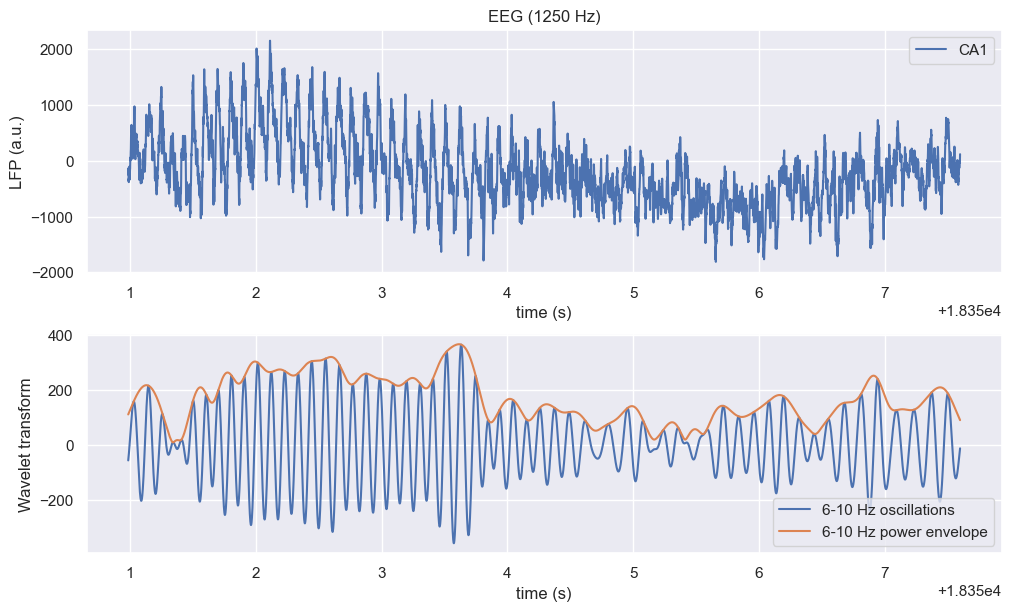

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.9])
ax0 = plt.subplot(gs[0, 0])
ax0.plot(eeg_example, label="CA1")
ax0.set_title("EEG (1250 Hz)")
ax0.set_ylabel("LFP (a.u.)")
ax0.set_xlabel("time (s)")
ax0.legend()
ax1 = plt.subplot(gs[1, 0])
ax1.plot(np.real(theta_band_reconstruction), label="6-10 Hz oscillations")
ax1.plot(theta_band_power_envelope, label="6-10 Hz power envelope")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("Wavelet transform")
ax1.legend()

***
We observe that the theta power is far stronger during the first 4 seconds of the dataset, during which the rat
is traversing the linear track.



***
Visualizing High Frequency Oscillation
-----------------------------------
There also seem to be peaks in the 200Hz frequency power after traversal of thew maze is complete. Here we use the interval (18356, 18357.5) seconds to zoom in.



Text(0.5, 0, 'Time (s)')

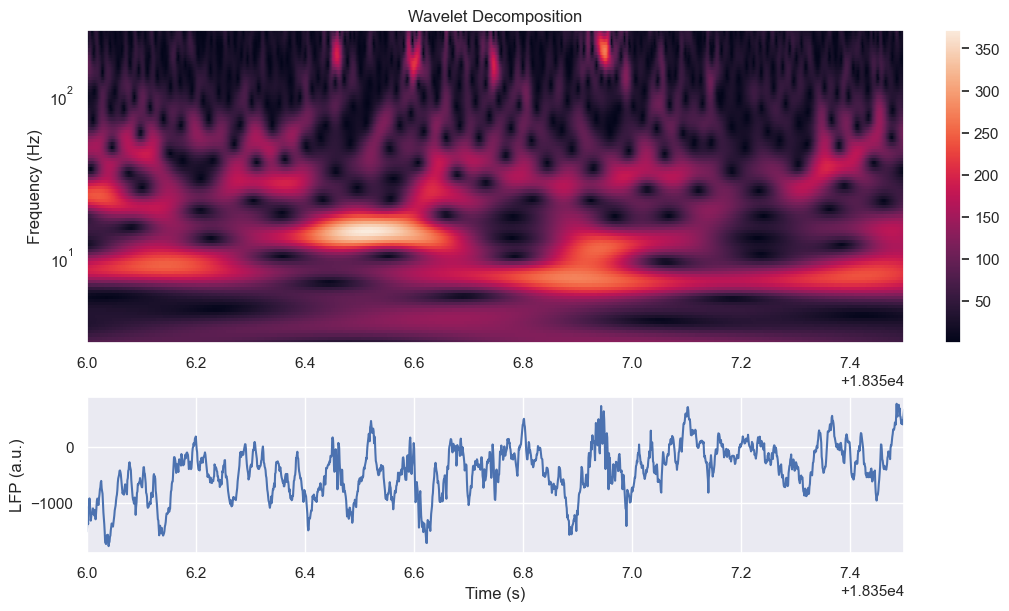

In [19]:
zoom_ep = nap.IntervalSet(18356.0, 18357.5)

mwt_zoom = mwt_RUN.restrict(zoom_ep)

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.5])
ax0 = plt.subplot(gs[0, 0])
pcmesh = ax0.pcolormesh(mwt_zoom.t, freqs, np.transpose(np.abs(mwt_zoom)))
ax0.grid(False)
ax0.set_yscale("log")
ax0.set_title("Wavelet Decomposition")
ax0.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pcmesh, ax=ax0, orientation="vertical")
ax0.set_label("Amplitude")

ax1 = plt.subplot(gs[1, 0], sharex=ax0)
ax1.plot(eeg_example.restrict(zoom_ep))
ax1.set_ylabel("LFP (a.u.)")
ax1.set_xlabel("Time (s)")

Those events are called Sharp-waves ripples [2].

Among other methods, we can use the Wavelet decomposition to isolate them. In this case, we will look at the power of the wavelets for frequencies between 150 to 250 Hz.



In [20]:
ripple_freq_index = np.logical_and(freqs > 150, freqs < 250)

We can compute the mean power for this frequency band.



In [21]:
ripple_power = np.mean(np.abs(mwt_RUN[:, ripple_freq_index]), 1)

Now let's visualise the 150-250 Hz mean amplitude of the wavelet decomposition over time



/var/folders/yf/0vy5wyyx3zq7l1_nt66mrrc00000gq/T/ipykernel_70976/4089558470.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


Text(0.5, 0, 'Time (s)')

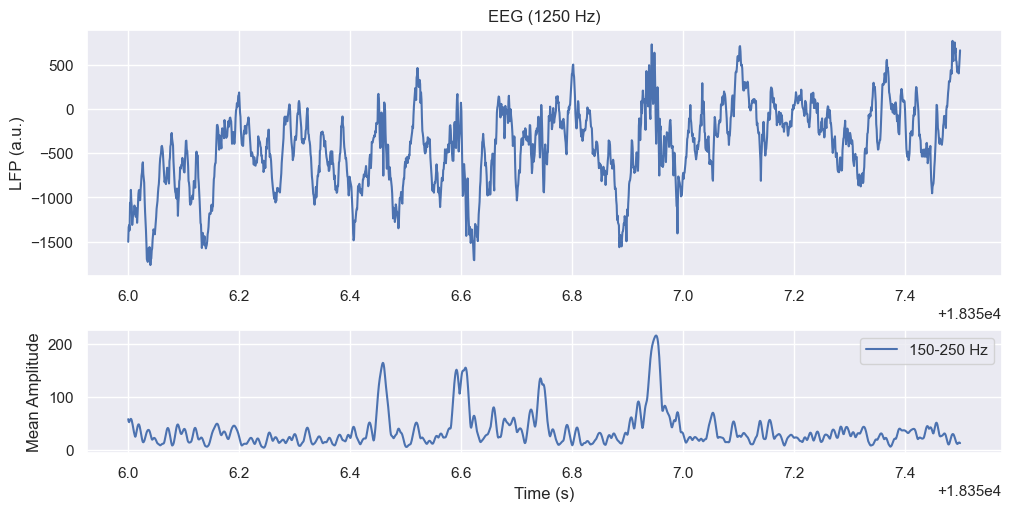

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.5])
ax0 = plt.subplot(gs[0, 0])
ax0.plot(eeg_example.restrict(zoom_ep), label="CA1")
ax0.set_ylabel("LFP (a.u.)")
ax0.set_title(f"EEG (1250 Hz)")
ax1 = plt.subplot(gs[1, 0])
ax1.legend()
ax1.plot(ripple_power.restrict(zoom_ep), label="150-250 Hz")
ax1.legend()
ax1.set_ylabel("Mean Amplitude")
ax1.set_xlabel("Time (s)")

It is then easy to isolate ripple times by using the pynapple functions `smooth` and `threshold`. In the following lines, `ripples` is smoothed with a gaussian kernel of size 0.005 second and thesholded with a value of 100.




In [23]:
smoothed_ripple_power = ripple_power.smooth(0.005)

threshold_ripple_power = smoothed_ripple_power.threshold(100)

`threshold_ripple_power` contains all the time points above 100. The ripple epochs are contained in the `time_support` of the threshold time series. Here we call it `rip_ep`.



In [24]:
rip_ep = threshold_ripple_power.time_support

Now let's plot the ripples epoch as well as the smoothed ripple power.

We can also plot `rip_ep` as vertical boxes to see if the detection is accurate



/var/folders/yf/0vy5wyyx3zq7l1_nt66mrrc00000gq/T/ipykernel_70976/1247125858.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


Text(0.5, 0, 'Time (s)')

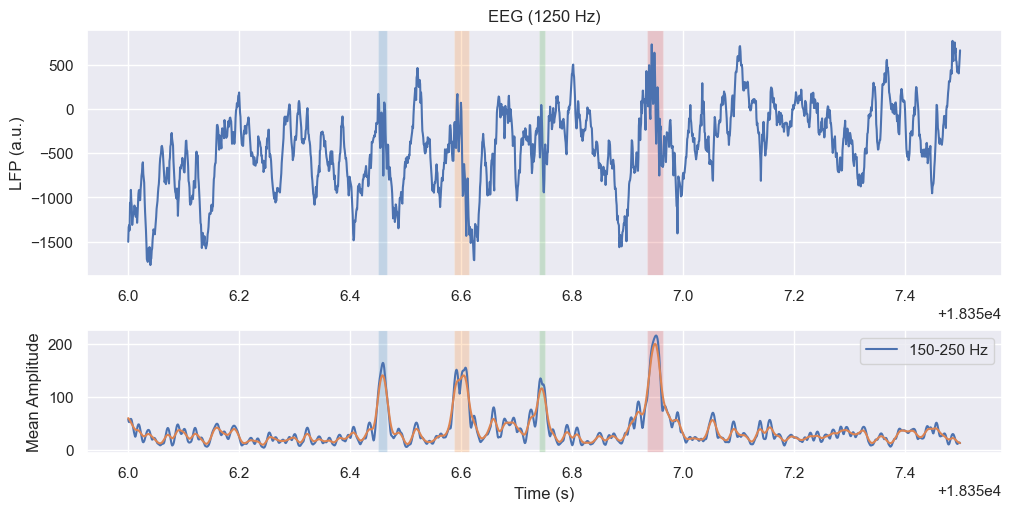

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.5])
ax0 = plt.subplot(gs[0, 0])
ax0.plot(eeg_example.restrict(zoom_ep), label="CA1")
for i, (s, e) in enumerate(rip_ep.intersect(zoom_ep).values):
    ax0.axvspan(s, e, color=list(mcolors.TABLEAU_COLORS.keys())[i], alpha=0.2, ec=None)
ax0.set_ylabel("LFP (a.u.)")
ax0.set_title(f"EEG (1250 Hz)")
ax1 = plt.subplot(gs[1, 0])
ax1.legend()
ax1.plot(ripple_power.restrict(zoom_ep), label="150-250 Hz")
ax1.plot(smoothed_ripple_power.restrict(zoom_ep))
for i, (s, e) in enumerate(rip_ep.intersect(zoom_ep).values):
    ax1.axvspan(s, e, color=list(mcolors.TABLEAU_COLORS.keys())[i], alpha=0.2, ec=None)
ax1.legend()
ax1.set_ylabel("Mean Amplitude")
ax1.set_xlabel("Time (s)")

Finally, let's zoom in on each of our isolated ripples



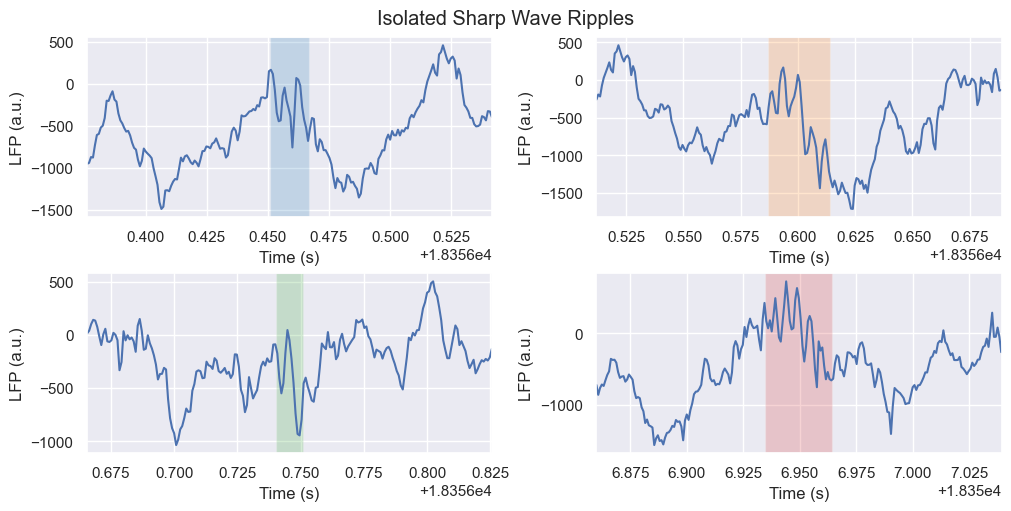

In [26]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = plt.GridSpec(2, 2, figure=fig, height_ratios=[1.0, 1.0])
buffer = 0.075
plt.suptitle("Isolated Sharp Wave Ripples")
for i, (s, e) in enumerate(rip_ep.intersect(zoom_ep).values):
    ax = plt.subplot(gs[int(i / 2), i % 2])
    ax.plot(eeg_example.restrict(nap.IntervalSet(s - buffer, e + buffer)))
    ax.axvspan(s, e, color=list(mcolors.TABLEAU_COLORS.keys())[i], alpha=0.2, ec=None)
    ax.set_xlim(s - buffer, e + buffer)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("LFP (a.u.)")

***
References
-----------------------------------

[1] Hasselmo, M. E., & Stern, C. E. (2014). Theta rhythm and the encoding and retrieval of space and time. Neuroimage, 85, 656-666.

[2] Buzsáki, G. (2015). Hippocampal sharp wave‐ripple: A cognitive biomarker for episodic memory and planning. Hippocampus, 25(10), 1073-1188.

